In [5]:
ENV["COLUMNS"] = 1000
ENV["LINES"]=1000

using ModelingToolkit, DifferentialEquations, Random, Distributions, Plots, CSV, OrdinaryDiffEq, Turing, DataFrames, Symbolics, Serialization
using NaNMath; nm=NaNMath
using StatsPlots; sp=StatsPlots
using ArviZ
using Optim
using Plots.PlotMeasures


In [7]:
# Define parameters
@parameters C_atp_wt C_adp_wt C_cit_wt C_amp_wt C_pi_wt C_g6p_wt C_g3p_wt C_dhap_wt C_GPI_wt C_PFKM_wt C_AMPK_wt C_ALD_wt # concentrations for wt
@parameters C_atp_zela C_adp_zela C_cit_zela C_amp_zela C_pi_zela C_g6p_zela C_g3p_zela C_dhap_zela C_GPI_zela C_PFKM_zela C_AMPK_zela C_ALD_zela # Concentrations for zela

@parameters PP_flux_wt PP_flux_zela # Flux though PP pathway

@parameters L_PFKM L_PFK2 # L values
@parameters Kcat_GPI Kcat_PFKM Kcat_AMPK Kcat_ALD

@parameters Vm_PFK2 Vm_FBP  # Vmax values. 
@parameters Keq_GPI Keq_PFKM Keq_PFK2 Keq_FBP Keq_ALD # K_eq for each enzyme

@parameters K_GPI_g6p K_GPI_f6p # For r_GPI
@parameters Ki_atp Ki_cit Ka_f6p Ka_f16bp Ka_amp Ka_f26bp # For N_PFKM Ki is inhibitors and Ka is activators
@parameters K_f6p K_atp K_f16bp K_adp # For r_PFKM
@parameters v_P # For psi
@parameters K2_atp K2_f6p K2_f26bp K2_adp # For r_PFK2. 2 refers to PFK2
@parameters K_FBP_f26bp K_FBP_f6p K_pi # For r_FBP
@parameters K_ALD_f16bp K_g3p K_dhap # For r_ALD

# Define variables
@independent_variables t
@variables f6p_wt(t) f16bp_wt(t) f26bp_wt(t) f6p_zela(t) f16bp_zela(t) f26bp_zela(t)

D = Differential(t)

# Define reaction rates for wild type
r_GPI_wt = C_GPI_wt*(Kcat_GPI/K_GPI_g6p)*(C_g6p_wt-(f6p_wt/Keq_GPI))/
    (1 + C_g6p_wt/K_GPI_g6p + f6p_wt/K_GPI_f6p)

N_PFKM_wt = 1 + L_PFKM*(1 + C_atp_wt/Ki_atp)^4*(1 + C_cit_wt/Ki_cit)^4/
    ((1 + f6p_wt/Ka_f6p + f16bp_wt/Ka_f16bp)^4 * (1 + C_amp_wt/Ka_amp)^4 * (1 + f26bp_wt/Ka_f26bp)^4)

r_PFKM_wt = ((C_PFKM_wt*(Kcat_PFKM/(K_f6p*K_atp))*(C_atp_wt*f6p_wt - C_adp_wt*f16bp_wt/Keq_PFKM))/
    ((1 + f6p_wt/K_f6p)*(1 + C_atp_wt/K_atp) + (1 + f16bp_wt/K_f16bp)*(1 + C_adp_wt/K_adp) -1))*
    (1/N_PFKM_wt)

psi_wt = (Kcat_AMPK*C_AMPK_wt)/((Kcat_AMPK*C_AMPK_wt)+v_P)
N_PFK2_wt = 1 + L_PFK2*(psi_wt/(1-psi_wt))^2

r_PFK2_wt = (Vm_PFK2/(K2_atp*K2_f6p))*((C_atp_wt*f6p_wt)-(C_adp_wt*f26bp_wt)/Keq_PFK2)/
    ((1+f6p_wt/K2_f6p)*(1+C_atp_wt/K2_atp) + (1+f26bp_wt/K2_f26bp)*(1+C_adp_wt/K2_adp) -1) *
    (1-(1/N_PFK2_wt))

r_FBP_wt = (Vm_FBP/(K_FBP_f26bp))*(f26bp_wt-(f6p_wt*C_pi_wt)/Keq_FBP)/
    ((1+f26bp_wt/K_FBP_f26bp) + (1+f6p_wt/K_FBP_f6p)*(1+C_pi_wt/K_pi)-1)

r_ALD_wt = C_ALD_wt*(Kcat_ALD/K_ALD_f16bp)*(f16bp_wt-(C_g3p_wt*C_dhap_wt)/Keq_ALD)/
    ((1 + f6p_wt/K_ALD_f16bp) + (1 + C_g3p_wt/K_g3p)*(1 + C_dhap_wt/K_dhap) -1)

# Define differential equations for wild type
eqs_wt = [D(f6p_wt) ~ r_GPI_wt - r_PFKM_wt - r_PFK2_wt + r_FBP_wt + PP_flux_wt,
    D(f16bp_wt) ~ r_PFKM_wt - r_ALD_wt,
    D(f26bp_wt) ~ r_PFK2_wt - r_FBP_wt]

@named sys_wt = ODESystem(eqs_wt, t)

# Simplify system for wild type
sys_wt=structural_simplify(sys_wt)

# Define reaction rates for zela 
r_GPI_zela = C_GPI_zela*(Kcat_GPI/K_GPI_g6p)*(C_g6p_zela-(f6p_zela/Keq_GPI))/
    (1 + C_g6p_zela/K_GPI_g6p + f6p_zela/K_GPI_f6p)

N_PFKM_zela = 1 + L_PFKM*(1 + C_atp_zela/Ki_atp)^4*(1 + C_cit_zela/Ki_cit)^4/
    ((1 + f6p_zela/Ka_f6p + f16bp_zela/Ka_f16bp)^4 * (1 + C_amp_zela/Ka_amp)^4 * (1 + f26bp_zela/Ka_f26bp)^4)

r_PFKM_zela = ((C_PFKM_zela*(Kcat_PFKM/(K_f6p*K_atp))*(C_atp_zela*f6p_zela - C_adp_zela*f16bp_zela/Keq_PFKM))/
    ((1 + f6p_zela/K_f6p)*(1 + C_atp_zela/K_atp) + (1 + f16bp_zela/K_f16bp)*(1 + C_adp_zela/K_adp) -1))*
    (1/N_PFKM_zela)

psi_zela = (Kcat_AMPK*C_AMPK_zela)/((Kcat_AMPK*C_AMPK_zela)+v_P)
N_PFK2_zela = 1 + L_PFK2*(psi_zela/(1-psi_zela))^2

r_PFK2_zela = (Vm_PFK2/(K2_atp*K2_f6p))*((C_atp_zela*f6p_zela)-(C_adp_zela*f26bp_zela)/Keq_PFK2)/
    ((1+f6p_zela/K2_f6p)*(1+C_atp_zela/K2_atp) + (1+f26bp_zela/K2_f26bp)*(1+C_adp_zela/K2_adp) -1) *
    (1-(1/N_PFK2_zela))

r_FBP_zela = (Vm_FBP/(K_FBP_f26bp))*(f26bp_zela-(f6p_zela*C_pi_zela)/Keq_FBP)/
    ((1+f26bp_zela/K_FBP_f26bp) + (1+f6p_zela/K_FBP_f6p)*(1+C_pi_zela/K_pi)-1)

r_ALD_zela = C_ALD_zela*(Kcat_ALD/K_ALD_f16bp)*(f16bp_zela-(C_g3p_zela*C_dhap_zela)/Keq_ALD)/
    ((1 + f6p_zela/K_ALD_f16bp) + (1 + C_g3p_zela/K_g3p)*(1 + C_dhap_zela/K_dhap) -1)

# Define differential equations for zela
eqs_zela = [D(f6p_zela) ~ r_GPI_zela - r_PFKM_zela - r_PFK2_zela + r_FBP_zela + PP_flux_zela,
    D(f16bp_zela) ~ r_PFKM_zela - r_ALD_zela,
    D(f26bp_zela) ~ r_PFK2_zela - r_FBP_zela]

@named sys_zela = ODESystem(eqs_zela, t)

# Simplify system for zela
sys_zela=structural_simplify(sys_zela)


Model sys_zela with 3 equations
Unknowns (3):
  f6p_zela(t)
  f16bp_zela(t)
  f26bp_zela(t)
Parameters (49):
  K_adp
  Ka_f16bp
  L_PFKM
  C_adp_zela
  Vm_FBP
  Ka_f26bp
  K2_f6p
  K_f16bp
  Ki_atp
  v_P
  Ka_amp
  Kcat_AMPK
  C_GPI_zela
  K_GPI_f6p
  Vm_PFK2
  L_PFK2
  K_f6p
  Keq_PFK2
  Kcat_PFKM
  PP_flux_zela
  Kcat_GPI
  Ka_f6p
  K_FBP_f6p
  Ki_cit
  C_g6p_zela
  C_PFKM_zela
  Keq_FBP
  K_pi
  C_cit_zela
  K2_atp
  C_pi_zela
  K2_f26bp
  Keq_PFKM
  K2_adp
  K_FBP_f26bp
  C_AMPK_zela
  Keq_GPI
  K_atp
  C_atp_zela
  C_amp_zela
  K_GPI_g6p
  Kcat_ALD
  K_ALD_f16bp
  K_g3p
  C_ALD_zela
  C_g3p_zela
  C_dhap_zela
  Keq_ALD
  K_dhap
Incidence matrix:3×6 SparseArrays.SparseMatrixCSC{Num, Int64} with 11 stored entries:
 ×  ×  ×  ×  ⋅  ⋅
 ×  ×  ×  ⋅  ×  ⋅
 ×  ⋅  ×  ⋅  ⋅  ×

In [8]:
# Define initial conditions and parameters
# Shared parameters 
Kcats = [Kcat_GPI => 1.912350597609562e7,
    Kcat_PFKM => 3.875*10^7,
    Kcat_AMPK => 5.732116666666667e-1,
    Vm_PFK2 => 41.6,
    Vm_FBP => 11.78, 
    Kcat_ALD => 2.800829875518672e5]    

L = [L_PFKM => 2*10^-1, 
    L_PFK2 => 1*10^-1]

Keq = [Keq_GPI => 2.9268, 
    Keq_PFKM => 480.09, 
    Keq_PFK2 => 16.0,
    Keq_FBP => 56.4458,  
    Keq_ALD => 0.0385]  

K = [K_GPI_g6p => 0.3,
    K_GPI_f6p => 0.123,
    Ki_atp => 0.1,
    Ki_cit => 0.1, 
    Ka_f6p => 0.4,
    Ka_f16bp => 0.35, 
    Ka_amp => 0.3,
    Ka_f26bp => 5.5e-3, 
    K_f6p => 6e-2,
    K_atp => 0.15, 
    K_f16bp => 0.35,
    K_adp => 0.54,
    v_P => 5e-6,
    K2_atp => 0.15,
    K2_f6p => 0.032,
    K2_f26bp => 0.008,
    K2_adp => 0.062,
    K_FBP_f26bp => 1e-3,
    K_FBP_f6p => 25e-3,
    K_pi => 0.23, #
    K_ALD_f16bp => 5e-2,
    K_g3p => 0.189,
    K_dhap => 3.5e-2] 

p1 = [Kcats; L; Keq; K];    

# Strain specific parameters
u0_wt = [f6p_wt => 1*10^-3,
    f16bp_wt => 1*10^-3,
    f26bp_wt => 1*10^-3]

u0_zela = [f6p_zela => 1*10^-3,
    f16bp_zela => 1*10^-3,
    f26bp_zela => 1*10^-3]   

Cons_wt = [C_atp_wt => exp(-5.647+log(1000)),
    C_adp_wt => exp(-6.619+log(1000)), 
    C_cit_wt => exp(-3.926+log(1000)),
    C_amp_wt => exp(-12.142+log(1000)),
    C_pi_wt => 1,
    C_g6p_wt => exp(-7.766+log(1000)),
    C_g3p_wt => exp(-9.513+log(1000)), 
    C_dhap_wt => exp(-13.055+log(1000)),
    C_GPI_wt => exp(-6.289), 
    C_PFKM_wt => exp(-10.037),
    C_AMPK_wt => exp(-9.764), 
    C_ALD_wt => exp(-5.653),
    PP_flux_wt => 8.8]
    
Cons_zela = [C_atp_zela => exp(-5.676+log(1000)), 
    C_adp_zela => exp(-6.774+log(1000)), 
    C_cit_zela => exp(-3.787+log(1000)),
    C_amp_zela => exp(-11.139+log(1000)),
    C_pi_zela => 1,
    C_g6p_zela => exp(-7.584+log(1000)),
    C_g3p_zela => exp(-10.174+log(1000)), 
    C_dhap_zela => exp(-10.069+log(1000)),
    C_GPI_zela => exp(-5.858),
    C_PFKM_zela => exp(-9.752),
    C_AMPK_zela => exp(-9.595), 
    C_ALD_zela => exp(-5.322),
    PP_flux_zela => 3.2];


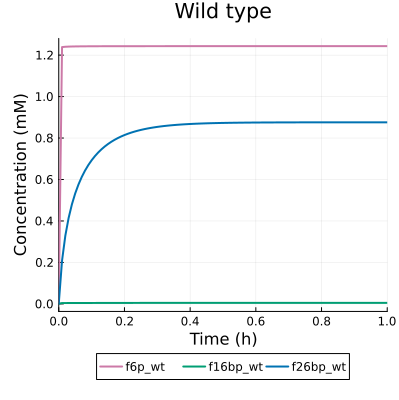

In [10]:
# Define time span
tspan = (0.0, 10)
p = [Cons_wt; Cons_zela; p1]

# Define and solve the ODE problem for wild type
prob_wt = ODEProblem(sys_wt, u0_wt, tspan, p, jac=true)
sol_wt = solve(prob_wt, Rodas4(), abstol=1e-12);
plt_sim_wt = plot(sol_wt, linewidth=2, seriescolor=[colorant"#CC79A7" colorant"#009E73" colorant"#0072B2"], xlims=(0,1), 
    xlabel="Time (h)", ylabel="Concentration (mM)", title="Wild type", 
    size=(400,400),
    legend=:outerbottom, legendcolumns=3,
    bottommargin=-30px)
savefig(plt_sim_wt, "ODE_sim_wt_model1.png") 
plt_sim_wt

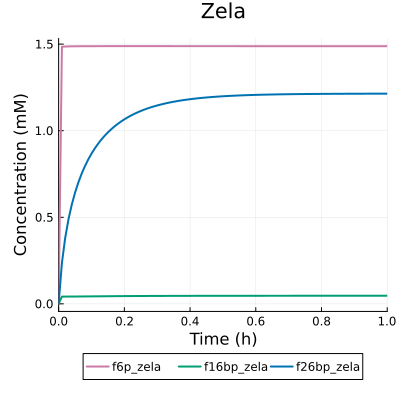

In [11]:
# Define and solve the ODE problem for zela
prob_zela=ODEProblem(sys_zela, u0_zela, tspan, p, jac=true)
sol_zela = solve(prob_zela, Rodas4(), abstol=1e-12);
plt_sim_zela = plot(sol_zela, linewidth=2, seriescolor=[colorant"#CC79A7" colorant"#009E73" colorant"#0072B2"], xlims=(0,1),
    xlabel="Time (h)", ylabel="Concentration (mM)", title="Zela", 
    size=(400,400),
    legend=:outerbottom, legendcolumns=3,
    bottommargin=-30px,)
savefig(plt_sim_zela, "ODE_sim_zela_model1.png") 
plt_sim_zela

In [12]:
# Calculate PFKM flux for each timestep for Wt
PFKM_flux_wt_state = []
for k in 1:size(sol_wt)[2]
    state_sol_wt = [f6p_wt => sol_wt[1,k],
        f16bp_wt => sol_wt[2,k],
        f26bp_wt => sol_wt[3,k]]
    push!(PFKM_flux_wt_state, substitute(r_PFKM_wt, [p; state_sol_wt]).val)
end

In [13]:
# Calculate PFKM flux for each timestep for Zela
PFKM_flux_zela_state = []
for k in 1:size(sol_zela)[2]
    state_sol_zela = [f6p_zela => sol_zela[1,k],
        f16bp_zela => sol_zela[2,k],
        f26bp_zela => sol_zela[3,k]]
    push!(PFKM_flux_zela_state, substitute(r_PFKM_zela, [p; state_sol_zela]).val)
end

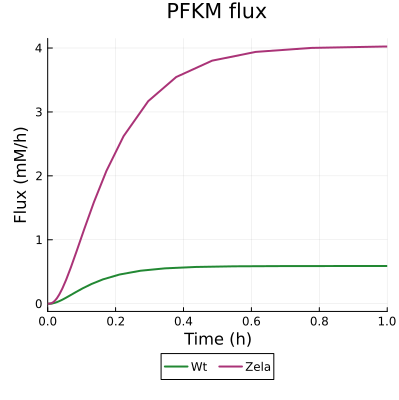

In [14]:
# Plot PFKM flux for Wt and Zela
plt_flux_wt = plot(sol_wt[:t], linewidth=2, PFKM_flux_wt_state, xlim=(0,1), label="Wt", color=colorant"#228833");
plt_flux = plot!(plt_flux_wt, sol_zela[:t], linewidth=2, PFKM_flux_zela_state, xlim=(0,1), label="Zela", color=colorant"#AA3377",
    title="PFKM flux", ylabel="Flux (mM/h)", xlabel="Time (h)", 
    size=(400,400),
    legend=:outerbottom, legendcolumns=2,
    bottommargin=-30px)
savefig(plt_flux, "ODE_sim_flux_model1.png")
plt_flux

In [15]:
# Calculate rates with defined parameters
r_GPI_para_wt = substitute(r_GPI_wt, p)
r_PFKM_para_wt = substitute(r_PFKM_wt, p)
r_PFK2_para_wt = substitute(r_PFK2_wt, p)
r_FBP_para_wt = substitute(r_FBP_wt, p)
r_ALD_para_wt = substitute(r_ALD_wt, p)
ss_para_wt = [
    f6p_wt => sol_wt[f6p_wt][end],
    f16bp_wt => sol_wt[f16bp_wt][end],
    f26bp_wt => sol_wt[f26bp_wt][end]]

# Calculate derivatives with steady state concentrations:
d_f6p = eval(substitute(r_GPI_para_wt, ss_para_wt) + substitute(r_FBP_para_wt, ss_para_wt) - substitute(r_PFKM_para_wt,ss_para_wt) - substitute(r_PFK2_para_wt, ss_para_wt) + 8.8)
d_f16bp = eval(substitute(r_PFKM_para_wt,ss_para_wt) - substitute(r_ALD_para_wt, ss_para_wt))
d_f26bp = eval(substitute(r_PFK2_para_wt, ss_para_wt) - substitute(r_FBP_para_wt, ss_para_wt))

println("D_f6p= ", d_f6p)
println("D_f16bp= ", d_f16bp)
println("D_f26bp= ", d_f26bp)
println(ss_para_wt)

D_f6p= 1.3645973240272724e-11
D_f16bp= 2.1856738641190532e-11
D_f26bp= 5.992159657353113e-9
Pair{Num, Float64}[f6p_wt(t) => 1.243228887960317, f16bp_wt(t) => 0.004896009161323674, f26bp_wt(t) => 0.8759168125919611]


In [16]:
# Experimental data for two strains (wild type(wt) and Zela)
g6p_wt = [-7.766+log(1000), 0.319]
g6p_zela = [-7.584+log(1000), 0.331]

dhap_wt = [-13.055+log(1000), 0.165]
dhap_zela = [-10.965+log(1000), 0.161]

g3p_wt = [-9.513+log(1000), 0.113]
g3p_zela = [-10.174+log(1000), 0.117]

atp_wt = [-5.647+log(1000), 0.163]
atp_zela = [-5.676+log(1000), 0.166]

adp_wt = [-6.619+log(1000), 0.167]
adp_zela = [-6.774+log(1000), 0.165]

amp_wt = [-12.142+log(1000), 0.261]
amp_zela = [-11.139+log(1000),  0.257]

cit_wt = [-3.926+log(1000), 0.219]
cit_zela = [-3.787+log(1000), 0.227]

fdp_wt = [exp(-7.261+log(1000)), 0.281] # fdp = f16bp. The exponential is taken to the mean-value
fdp_zela = [exp(-4.856+log(1000)), 0.239] # fdp = f16bp. The exponential is taken to the mean-value

f6p_wt_val = [exp(-7.760+log(1000)), 0.314] # The exponential is taken to the mean-value
f6p_zela_val = [exp(-7.594+log(1000)), 0.311] # The exponential is taken to the mean-value

pep_wt = [-12.586+log(1000), 0.341]
pep_zela = [-11.229+log(1000), 0.339]

# enzyme concentrations
GPI_wt = [-6.289, 0.185]
GPI_zela = [-5.858, 0.103]

PFKM_wt = [-10.037, 0.165]
PFKM_zela = [-9.752, 0.216]

AMPK_wt = [-9.764, 0.087]
AMPK_zela = [-9.595, 0.090]

ALDO_wt = [-5.653, 0.263]
ALDO_zela = [-5.322, 0.079]

data_wt = [atp_wt adp_wt cit_wt amp_wt pep_wt g6p_wt g3p_wt dhap_wt GPI_wt PFKM_wt AMPK_wt ALDO_wt f6p_wt_val fdp_wt]
data_zela = [atp_zela adp_zela cit_zela amp_zela pep_zela g6p_zela g3p_zela dhap_zela GPI_zela PFKM_zela AMPK_zela ALDO_zela f6p_zela_val fdp_zela]

pp_flux_wt = [2*0.0044*1000, 2*8.14*10^-1] 
pp_flux_zela = [2*0.0016*1000, 2*6.22*10^-1] 

PFK_flux_wt = [0.1333*1000,	0.0028*10^3] 
PFK_flux_zela = [0.0801*1000, 0.0035*10^3] 

flux_vec = [PFK_flux_wt PFK_flux_zela]

2×2 Matrix{Float64}:
 133.3  80.1
   2.8   3.5

In [17]:
p_names = [C_atp_wt, C_adp_wt, C_cit_wt, C_amp_wt, C_pi_wt, C_g6p_wt, C_g3p_wt, C_dhap_wt, C_GPI_wt, C_PFKM_wt, C_AMPK_wt, C_ALD_wt, PP_flux_wt, C_atp_zela, C_adp_zela, C_cit_zela, C_amp_zela, C_pi_zela, C_g6p_zela, C_g3p_zela, C_dhap_zela, C_GPI_zela, C_PFKM_zela, C_AMPK_zela, C_ALD_zela, PP_flux_zela, Kcat_GPI, Kcat_PFKM, Kcat_AMPK, Vm_PFK2, Vm_FBP, Kcat_ALD, L_PFKM, L_PFK2, Keq_GPI, Keq_PFKM, Keq_PFK2, Keq_FBP, Keq_ALD, K_GPI_g6p, K_GPI_f6p, Ki_atp, Ki_cit, Ka_f6p, Ka_f16bp, Ka_amp, Ka_f26bp, K_f6p, K_atp, K_f16bp, K_adp, v_P, K2_atp, K2_f6p, K2_f26bp, K2_adp, K_FBP_f26bp, K_FBP_f6p, K_pi, K_ALD_f16bp, K_g3p, K_dhap];

In [18]:
# define log-likelihood functions
function llik_conc(meas, mean, sd)
    return log(1/(meas*sqrt(2*pi*sd^2))) - (log(meas)-log(mean))^2/(2*sd^2)
end
 
function llik_flux(meas, mean, sd)
    return log(1/(sqrt(2*pi*sd^2))) - (meas-mean)^2/(2*sd^2)
end

llik_flux (generic function with 1 method)

In [19]:
# Define the Bayesian model
@model function mymodelRodas4(data_wt, data_zela, prob_wt, prob_zela, flux, likelihood)
    C_atp_wt ~ LogNormal(data_wt[1,1], data_wt[2,1])
    C_adp_wt ~ LogNormal(data_wt[1,2], data_wt[2,2]) 
    C_cit_wt ~ LogNormal(data_wt[1,3], data_wt[2,3])
    C_amp_wt ~ LogNormal(data_wt[1,4], data_wt[2,4])
    C_pi_wt ~ LogNormal(log(1), 1)
    C_g6p_wt ~ LogNormal(data_wt[1,6], data_wt[2,6]) 
    C_g3p_wt ~ LogNormal(data_wt[1,7], data_wt[2,7]) 
    C_dhap_wt ~ LogNormal(data_wt[1,8], data_wt[2,8])
    C_GPI_wt ~ LogNormal(data_wt[1,9], data_wt[2,9])
    C_PFKM_wt ~ LogNormal(data_wt[1,10], data_wt[2,10])
    C_AMPK_wt ~ LogNormal(data_wt[1,11], data_wt[2,11])
    C_ALD_wt ~ LogNormal(data_wt[1,12], data_wt[2,12])
    PP_flux_wt ~ Normal(8.8, 1.628)
    
    Cons_wt = [C_atp_wt, C_adp_wt, C_cit_wt, C_amp_wt, C_pi_wt ,C_g6p_wt, C_g3p_wt, C_dhap_wt, C_GPI_wt, C_PFKM_wt, C_AMPK_wt, C_ALD_wt, PP_flux_wt]

    C_atp_zela ~ LogNormal(data_zela[1,1], data_zela[2,1]) 
    C_adp_zela ~ LogNormal(data_zela[1,2], data_zela[2,2]) 
    C_cit_zela ~ LogNormal(data_zela[1,3], data_zela[2,3])
    C_amp_zela ~ LogNormal(data_zela[1,4], data_zela[2,4])
    C_pi_zela ~ LogNormal(log(1), 1)
    C_g6p_zela ~ LogNormal(data_zela[1,6], data_zela[2,6]) 
    C_g3p_zela ~ LogNormal(data_zela[1,7], data_zela[2,7])
    C_dhap_zela ~ LogNormal(data_zela[1,8], data_zela[2,8])
    C_GPI_zela ~ LogNormal(data_zela[1,9], data_zela[2,9])
    C_PFKM_zela ~ LogNormal(data_zela[1,10], data_zela[2,10])
    C_AMPK_zela ~ LogNormal(data_zela[1,11], data_zela[2,11])
    C_ALD_zela ~ LogNormal(data_zela[1,12], data_zela[2,12])
    PP_flux_zela ~ Normal(3.2, 1.244)
    
    Cons_zela = [C_atp_zela, C_adp_zela, C_cit_zela, C_amp_zela, C_pi_zela, C_g6p_zela, C_g3p_zela, C_dhap_zela, C_GPI_zela, C_PFKM_zela, C_AMPK_zela, C_ALD_zela, PP_flux_zela]

    Kcat_GPI ~ LogNormal(log(1.912350597609562e7), 2) 
    Kcat_PFKM ~ LogNormal(log(3.875e7), 2) 
    Kcat_AMPK ~ LogNormal(log(5.73), 2) 
    Vm_PFK2 ~ LogNormal(log(41.6), 2) 
    Vm_FBP ~ LogNormal(log(11.78), 2)
    Kcat_ALD ~ LogNormal(log(2.8e5), 2) 

    L_PFKM ~ LogNormal(log(2e-1), 2.5) 
    L_PFK2 ~ LogNormal(log(1e-1), 2.5)

    Keq_GPI ~  LogNormal(log(2.92),1.5)
    Keq_PFKM ~ LogNormal(log(480),1.5)
    Keq_PFK2 ~ LogNormal(log(16.0), 1.5)
    Keq_FBP ~ LogNormal(log(56.4458), 1.5)
    Keq_ALD ~ LogNormal(log(0.0385), 1.5) 

    K_GPI_g6p ~ LogNormal(log(0.3),1)
    K_GPI_f6p ~ LogNormal(log(0.123),1) 
    Ki_atp ~ LogNormal(1.26,2)
    Ki_cit ~ LogNormal(2.98,2) 
    Ka_f6p ~ LogNormal(log(0.43),2) 
    Ka_f16bp ~ LogNormal(log(0.70),2) 
    Ka_amp ~ LogNormal(-5.23,2) 
    Ka_f26bp ~ LogNormal(log(5.5*10^-3),2)
    K_f6p ~ LogNormal(log(6*10^-2),1)
    K_atp ~ LogNormal(log(0.15),1)
    K_f16bp ~ LogNormal(log(0.35),1)
    K_adp ~ LogNormal(log(0.54),1)
    v_P ~ LogNormal(log(5*10^-6),2)
    K2_atp ~ LogNormal(log(0.15),1)
    K2_f6p ~ LogNormal(log(0.032),1)
    K2_f26bp ~ LogNormal(log(0.008),1)
    K2_adp ~ LogNormal(log(0.062),1)
    K_FBP_f26bp ~ LogNormal(log(1*10^-3),1)
    K_FBP_f6p ~ LogNormal(log(25*10^-3),1)
    K_pi ~ LogNormal(log(0.23),1) #
    K_ALD_f16bp ~ LogNormal(log(5*10^-2),1)
    K_g3p ~ LogNormal(log(0.189),1)
    K_dhap ~ LogNormal(log(3.5*10^-2),1) 

    p_same = [Kcat_GPI, Kcat_PFKM, Kcat_AMPK, Vm_PFK2, Vm_FBP, Kcat_ALD, L_PFKM, L_PFK2, Keq_GPI, Keq_PFKM, Keq_PFK2, Keq_FBP, Keq_ALD, K_GPI_g6p, K_GPI_f6p, Ki_atp, Ki_cit, Ka_f6p, Ka_f16bp, Ka_amp, Ka_f26bp, K_f6p, K_atp, K_f16bp, K_adp, v_P, K2_atp, K2_f6p, K2_f26bp, K2_adp, K_FBP_f26bp, K_FBP_f6p, K_pi, K_ALD_f16bp, K_g3p, K_dhap]
    p_total = [Cons_wt; Cons_zela; p_same]
    
    sol_wt = solve(prob_wt, Rodas4(); p=p_total, save_everystep=false, abstol = 1e-12)
    ss_wt = sol_wt[end]

    sol_zela = solve(prob_zela, Rodas4(); p=p_total, save_everystep = false, abstol = 1e-12)
    ss_zela = sol_zela[end]

    p_pair = Pair.(p_names, p_total) 

    ss_wt_pair = [f6p_wt => ss_wt[1],
        f16bp_wt => ss_wt[2],
        f26bp_wt => ss_wt[3]]

    
    PFKM_flux_wt = substitute(r_PFKM_wt, [p_pair; ss_wt_pair])
    PFKM_flux_wt_float = PFKM_flux_wt.val

    ss_zela_pair = [f6p_zela => ss_zela[1],
        f16bp_zela => ss_zela[2],
        f26bp_zela => ss_zela[3]]

    PFKM_flux_zela = substitute(r_PFKM_zela, [p_pair; ss_zela_pair])
    PFKM_flux_zela_float = PFKM_flux_zela.val

    # If likelihood = 0: Samples from prior distributions
    # If likelihood = 1: Samples from posterior distribtions
    if likelihood == 1
        data_wt[1,13] ~ LogNormal(nm.log(ss_wt[1]), data_wt[2,13])
        data_wt[1,14] ~ LogNormal(nm.log(ss_wt[2]), data_wt[2,14])

        data_zela[1,13] ~ LogNormal(nm.log(ss_zela[1]), data_zela[2,13])
        data_zela[1,14] ~ LogNormal(nm.log(ss_zela[2]), data_zela[2,14])

        flux[1,1] ~ Normal(PFKM_flux_wt_float, flux[2,1])
        flux[1,2] ~ Normal(PFKM_flux_zela_float, flux[2,2])
    end

end

mymodelRodas4 (generic function with 2 methods)

In [20]:
# Define initial values
inits = []
for x in p
     push!(inits, x.second)
end

init_vec = [inits, inits]

2-element Vector{Vector{Any}}:
 [3.528085169903056, 1.3347650434967395, 19.72240460240018, 0.005330849242110898, 1.0, 0.42390550209055616, 0.07388505375938664, 0.0021393682131900737, 0.0018566156344915368, 4.3750828858629836e-5  …  0.15, 0.032, 0.008, 0.062, 0.001, 0.025, 0.23, 0.05, 0.189, 0.035]
 [3.528085169903056, 1.3347650434967395, 19.72240460240018, 0.005330849242110898, 1.0, 0.42390550209055616, 0.07388505375938664, 0.0021393682131900737, 0.0018566156344915368, 4.3750828858629836e-5  …  0.15, 0.032, 0.008, 0.062, 0.001, 0.025, 0.23, 0.05, 0.189, 0.035]

In [21]:
# Prior sampling
likelihood = 0
model = mymodelRodas4(data_wt, data_zela, prob_wt, prob_zela, flux_vec, likelihood)
sampler = NUTS(10, 0.95)
samples = 10
parallel_type = MCMCThreads()
n_chains = 2
# Uncomment to sample:
prior = sample(model, sampler, parallel_type, samples, n_chains, initial_params = init_vec)

In [ ]:
# Save samples from prior distribution
#serialize("Model1_prior.jls", prior)

# Load samples from prior distribution
# prior = deserialize("Model1_prior.jls");

In [ ]:
# Get a vector with all parameters and their order. Used to check that the order of all vectors containing parameters are in the same order as in the Turing model.
#prior.name_map.parameters

In [ ]:
# Make a dataframe of the sampled prior distributions
prior_df = DataFrame(prior);

In [ ]:
# Solve ODE with each sampled set of parameters
p_prior = select(prior_df, :C_atp_wt, :C_adp_wt, :C_cit_wt, :C_amp_wt, :C_pi_wt, :C_g6p_wt, :C_g3p_wt, :C_dhap_wt, :C_GPI_wt, :C_PFKM_wt, :C_AMPK_wt, :C_ALD_wt, :PP_flux_wt, :C_atp_zela, :C_adp_zela, :C_cit_zela, :C_amp_zela, :C_pi_zela, :C_g6p_zela, :C_g3p_zela, :C_dhap_zela, :C_GPI_zela, :C_PFKM_zela, :C_AMPK_zela, :C_ALD_zela, :PP_flux_zela, :Kcat_GPI, :Kcat_PFKM, :Kcat_AMPK, :Vm_PFK2, :Vm_FBP, :Kcat_ALD, :L_PFKM, :L_PFK2, :Keq_GPI, :Keq_PFKM, :Keq_PFK2, :Keq_FBP, :Keq_ALD, :K_GPI_g6p, :K_GPI_f6p, :Ki_atp, :Ki_cit, :Ka_f6p, :Ka_f16bp, :Ka_amp, :Ka_f26bp, :K_f6p, :K_atp, :K_f16bp, :K_adp, :v_P, :K2_atp, :K2_f6p, :K2_f26bp, :K2_adp, :K_FBP_f26bp, :K_FBP_f6p, :K_pi, :K_ALD_f16bp, :K_g3p, :K_dhap)
tspan = (0,1e3)
ss_prior_wt = zeros(size(p_prior)[1],3)
ss_prior_zela = zeros(size(p_prior)[1],3)
PFKM_flux_zela_vec_prior = []
PFKM_flux_wt_vec_prior = []
p_pair_prior = []
i=1
for p_loop in eachrow(Array(p_prior))
    p_pair_prior = Pair.(p_names, p_loop)  

    prob_wt_loop = ODEProblem(sys_wt, u0_wt, tspan, p_pair_prior, jac=true)
    sol_wt_loop = solve(prob_wt_loop, Rodas4(), abstol = 1e-12);
    ss_prior_wt[i,:] = sol_wt_loop[end]

    prob_zela_loop = ODEProblem(sys_zela, u0_zela, tspan, p_pair_prior, jac = true)
    sol_zela_loop = solve(prob_zela_loop, Rodas4(), abstol = 1e-12);
    ss_prior_zela[i,:] = sol_zela_loop[end]

    ss_wt_loop = [f6p_wt => ss_prior_wt[1],
        f16bp_wt => ss_prior_wt[2],
        f26bp_wt => ss_prior_wt[3]]

    ss_zela_loop = [f6p_zela => ss_prior_zela[1],
        f16bp_zela => ss_prior_zela[2],
        f26bp_zela => ss_prior_zela[3]]
    
    push!(PFKM_flux_wt_vec_prior, substitute(r_PFKM_wt, [p_pair_prior; ss_wt_loop]))
    push!(PFKM_flux_zela_vec_prior, substitute(r_PFKM_zela, [p_pair_prior; ss_zela_loop]))

    i = i+1
end 

# Convert PFKM flux from num to float
PFKM_flux_wt_vec_prior_float = [i.val for i in PFKM_flux_wt_vec_prior];
PFKM_flux_zela_vec_prior_float = [i.val for i in PFKM_flux_zela_vec_prior];

In [ ]:
# Plot histograms from steady state concentrations and PFKM flux
left_margin_size = 20*Plots.mm
plt1_wt = histogram(ss_prior_wt[:,1], bin=30, 
        title = "f6p",
        label = "f6p wt", 
        xlabel = "mM",
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 200),
        left_margin=left_margin_size)
    vline!(plt1_wt, [f6p_wt_val[1]], linewidth = 2, linecolor=colorant"#CC6677", label = "Measurement")

plt2_wt = histogram(ss_prior_wt[:,2], bin=30, 
        title = "f16bp",
        label = "f16bp wt", 
        xlabel = "mM", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300))
    vline!(plt2_wt, [fdp_wt[1]], linewidth = 2, linecolor = colorant"#CC6677", label = "Measurement")

plt3_wt = histogram(ss_prior_wt[:,3], bin=30, 
        title = "f26bp",
        label = "f26bp wt", 
        xlabel = "mM", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300))

plt4_wt = histogram(PFKM_flux_wt_vec_prior_float, bin=30, 
        title = "PFKM flux",
        label = "SS from prior distribution",
        xlabel = "mM/h", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = true,
        size = (300, 300))
    vline!(plt4_wt, [flux_vec[1,1]], linewidth = 2, linecolor = colorant"#CC6677", label = "Measurement")

plt1_zela = histogram(ss_prior_zela[:,1], bin=30, 
        label = "SS from prior distribution", 
        xlabel = "mM", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300),
        left_margin = left_margin_size)
    vline!(plt1_zela, [f6p_zela_val[1]], linewidth = 2, linecolor = colorant"#CC6677", label = "Measurement mean")

plt2_zela = histogram(ss_prior_zela[:,2], bin =30, 
        label = "f16bp zela",
        xlabel = "mM", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300))
    vline!(plt2_zela, [fdp_zela[1]], linewidth = 2, linecolor = colorant"#CC6677", label = "Measurement mean")

plt3_wt = histogram(ss_prior_zela[:,3], bin=30, 
        title = "f26bp",
        label = "f26bp zela", 
        xlabel = "mM", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300))

plt4_zela = histogram(PFKM_flux_zela_vec_prior_float, bin=30, 
        label = "PFKM flux zela",
        xlabel = "mM/h", 
        ylabel = "Density",
        normalize=:probability,
        fillcolor = colorant"#44AA99",
        legend = false,
        size = (300, 300))
    vline!(plt4_zela, [flux_vec[1,2]], linewidth = 2, linecolor = colorant"#CC6677", label = "Measurement")
    
combined_plot = plot(plt1_wt, plt2_wt, plt4_wt, plt1_zela, plt2_zela, plt4_zela, layout = (2,3), size = (1000, 600), link = :both, bottommargin=10px ) 

# Add row title for the first row
annotate!(subplot = 1, -100, 0.5, text("Wild type", :right, 16, :center, rotation=90))

# Add row title for the second row
annotate!(subplot = 4, -100, 0.5, text("Zela", :right, 16,:center, rotation=90))

savefig(combined_plot, "Prior_hist_model1")
display(combined_plot)



In [ ]:
# Make a dataframe of solutions from ODE solving:
df_model1_prior = DataFrame(f6p_wt = ss_prior_wt[:,1], f16bp_wt = ss_prior_wt[:,2], f26bp_wt = ss_prior_wt[:,3], PFKM_flux_wt = PFKM_flux_wt_vec_prior_float, f6p_zela = ss_prior_zela[:,1], f16bp_zela = ss_prior_zela[:,2], f26bp_zela = ss_prior_zela[:,3], PFKM_flux_zela = PFKM_flux_zela_vec_prior_float);

In [ ]:
# Save solutions from ODE solving:
# CSV.write("Model1_ss_dataframe_prior.CSV", df_model1_prior)

# Load solutions from ODE solving:
# df_model1_post = DataFrame(CSV.File("Model1_ss_dataframe_prior.CSV"))

From here it is sampled from posterior distributions

In [ ]:
# Sampling from posterior Distributions
likelihood = 1
model = mymodelRodas4(data_wt, data_zela, prob_wt, prob_zela, flux_vec, likelihood)
sampler = NUTS(1000, 0.95)
samples = 1000
parallel_type = MCMCThreads()
n_chains = 2;

# Uncomment to sample:
#chain = sample(model, sampler, parallel_type, samples, n_chains, initial_params = init_vec)

In [ ]:
# Save chains from posterior sampling
# serialize("Model1_chains.jls", chain)

# Load chains from posterior sampling
chain = deserialize("Model1_chains.jls")

In [ ]:
# Minimum and maximum of rhat-values
println(minimum(summarystats(chain)[:,7]))
println(maximum(summarystats(chain)[:,7]))

In [ ]:
# Number of rhat values above 1.1
sum(summarystats(chain)[:,7] .> 1.1)

In [ ]:
# Plot of Kcat_PFKM
plot(chain[[:Kcat_PFKM]])

In [ ]:
# Plot for L_PFKM
plot(chain[[:L_PFKM]])

In [ ]:
# Calculate summarystats and define dataframe from chains
sum_stats = summarystats(chain);
chain_df = DataFrame(chain);
para_mean = sum_stats[:,2];

In [ ]:
# Solve steady states from each samples set of parameters from posterior distribution
p_post = select(chain_df, :C_atp_wt, :C_adp_wt, :C_cit_wt, :C_amp_wt, :C_pi_wt, :C_g6p_wt, :C_g3p_wt, :C_dhap_wt, :C_GPI_wt, :C_PFKM_wt, :C_AMPK_wt, :C_ALD_wt, :PP_flux_wt, :C_atp_zela, :C_adp_zela, :C_cit_zela, :C_amp_zela, :C_pi_zela, :C_g6p_zela, :C_g3p_zela, :C_dhap_zela, :C_GPI_zela, :C_PFKM_zela, :C_AMPK_zela, :C_ALD_zela, :PP_flux_zela, :Kcat_GPI, :Kcat_PFKM, :Kcat_AMPK, :Vm_PFK2, :Vm_FBP, :Kcat_ALD, :L_PFKM, :L_PFK2, :Keq_GPI, :Keq_PFKM, :Keq_PFK2, :Keq_FBP, :Keq_ALD, :K_GPI_g6p, :K_GPI_f6p, :Ki_atp, :Ki_cit, :Ka_f6p, :Ka_f16bp, :Ka_amp, :Ka_f26bp, :K_f6p, :K_atp, :K_f16bp, :K_adp, :v_P, :K2_atp, :K2_f6p, :K2_f26bp, :K2_adp, :K_FBP_f26bp, :K_FBP_f6p, :K_pi, :K_ALD_f16bp, :K_g3p, :K_dhap);
tspan = (0,1e3)
ss_post_wt = zeros(size(p_post)[1],3)
ss_post_zela = zeros(size(p_post)[1],3)
PFKM_flux_zela_vec_post = []
PFKM_flux_wt_vec_post = []
PFK2_flux_zela_vec_post = []
PFK2_flux_wt_vec_post = []
PFKM_allo_wt_vec = []
PFKM_allo_zela_vec = []
p_pair_post = []
i=1
for p_loop in eachrow(Array(p_post))
    p_pair_post= Pair.(p_names, p_loop)  

    prob_wt_loop = ODEProblem(sys_wt, u0_wt, tspan, p_pair_post, jac = true)
    sol_wt_loop = solve(prob_wt_loop, Rodas4(), abstol = 1e-12);
    ss_post_wt[i,:] = sol_wt_loop[end]

    prob_zela_loop = ODEProblem(sys_zela, u0_zela, tspan, p_pair_post, jac = true)
    sol_zela_loop = solve(prob_zela_loop, Rodas4(), abstol = 1e-12);
    ss_post_zela[i,:] = sol_zela_loop[end]

    ss_wt = [f6p_wt => ss_post_wt[1],
        f16bp_wt => ss_post_wt[2],
        f26bp_wt => ss_post_wt[3]]

    ss_zela = [f6p_zela => ss_post_zela[1],
        f16bp_zela => ss_post_zela[2],
        f26bp_zela => ss_post_zela[3]]

    push!(PFKM_flux_wt_vec_post, substitute(r_PFKM_wt, [p_pair_post; ss_wt]))
    push!(PFKM_flux_zela_vec_post, substitute(r_PFKM_zela, [p_pair_post; ss_zela]))

    push!(PFK2_flux_wt_vec_post, substitute(r_PFK2_wt, [p_pair_post; ss_wt]))
    push!(PFK2_flux_zela_vec_post, substitute(r_PFK2_zela, [p_pair_post; ss_zela]))

    push!(PFKM_allo_wt_vec, 1/substitute(N_PFKM_wt, [p_pair_post; ss_wt]))
    push!(PFKM_allo_zela_vec, 1/substitute(N_PFKM_zela, [p_pair_post; ss_zela]))

    i = i+1
end 

# Convert from num to float
PFKM_flux_wt_vec_post_float = [i.val for i in PFKM_flux_wt_vec_post];
PFKM_flux_zela_vec_post_float = [i.val for i in PFKM_flux_zela_vec_post];
PFK2_flux_wt_vec_post_float = [i.val for i in PFK2_flux_wt_vec_post];
PFK2_flux_zela_vec_post_float = [i.val for i in PFK2_flux_zela_vec_post];
PFKM_allo_wt_vec_float = [i.val for i in PFKM_allo_wt_vec];
PFKM_allo_zela_vec_float = [i.val for i in PFKM_allo_zela_vec];

In [ ]:
# Define a dataframe of solutions from ODE solving:
df_model1_post = DataFrame(f6p_wt = ss_post_wt[:,1], f16bp_wt = ss_post_wt[:,2], f26bp_wt = ss_post_wt[:,3], PFKM_flux_wt = PFKM_flux_wt_vec_post_float, f6p_zela = ss_post_zela[:,1], f16bp_zela = ss_post_zela[:,2], f26bp_zela = ss_post_zela[:,3], PFKM_flux_zela = PFKM_flux_zela_vec_post_float);

In [ ]:
# Save dataframe of solutions from ODE solving:
# CSV.write("Model1_ss_dataframe_post.CSV", df_model1_post)
# df_model1_post = DataFrame(CSV.File("Model1_ss_dataframe_post.CSV"))

In [ ]:
# plot of intervals for steady state concentrations
sp.plot([sp.quantile!(ss_post_wt[:,1], 0.025), sp.quantile!(ss_post_wt[:,1], 0.975)], [1,1], label = "f6p", xlabel = "steady state values", linecolor = colorant"#44AA99")
sp.plot!([sp.quantile!(ss_post_wt[:,2], 0.025), sp.quantile!(ss_post_wt[:,2], 0.975)], [1.1,1.1], label = "f16bp")
sp.plot!([sp.quantile!(ss_post_wt[:,3], 0.025), sp.quantile!(ss_post_wt[:,3], 0.975)], [0.9,0.9], label = "f26bp")
sp.plot!([sp.quantile!(ss_post_zela[:,1], 0.025), sp.quantile!(ss_post_zela[:,1], 0.975)], [0.99,0.99], label = "f6p zela", xlabel = "steady state values")
sp.plot!([sp.quantile!(ss_post_zela[:,2], 0.025), sp.quantile!(ss_post_zela[:,2], 0.975)], [1.09,1.09], label = "f16bp zela")
sp.plot!([sp.quantile!(ss_post_zela[:,3], 0.025), sp.quantile!(ss_post_zela[:,3], 0.975)], [0.89,0.89], label = "f26bp zela")

In [ ]:
# Plot of steady state flux
sp.plot([sp.quantile!(PFKM_flux_wt_vec_post_float, 0.025), sp.quantile!(PFKM_flux_wt_vec_post_float, 0.975)], [0.9,0.9], label = "PFKM flux wt 95%", legend = :right) # 95 %
sp.plot!([sp.quantile!(PFKM_flux_zela_vec_post_float, 0.025), sp.quantile!(PFKM_flux_zela_vec_post_float, 0.975)], [0.8,0.8], label = "PFKM flux zela 95%") # 95 %
sp.plot!([flux_vec[1,1],flux_vec[1,1]], [0.89, 0.91], label = " wt measurement") # 95 %
sp.plot!([flux_vec[1,2],flux_vec[1,2]], [0.79, 0.81], label = " zela measurement") 

In [ ]:
# Convert to inference data
idata_turing = from_mcmcchains(
    chain;
    prior, 
    library="Turing",
)

In [ ]:
# check of diverging
println("Total # diverging samples: ", sum(idata_turing[:sample_stats][:diverging]))
println("# diverging samples in chain 1: ", sum(idata_turing[:sample_stats][:diverging][:,1]))
println("# diverging samples in chain 2: ", sum(idata_turing[:sample_stats][:diverging][:,2]))

In [ ]:
# Sammarize by Arviz
ArviZ.summarize(idata_turing[:sample_stats], mean, std, rhat)

In [ ]:
# Calculate ratios for metabolites
f6p_ratio = log.(ss_post_wt[:,1]./ss_post_zela[:,1]);
f16bp_ratio = log.(ss_post_wt[:,2]./ss_post_zela[:,2]);

f6p_ratio_meas = log(f6p_wt_val[1]/f6p_zela_val[1])
f16bp_ratio_meas = log(fdp_wt[1]/fdp_zela[1])
println("f6p: ", f6p_ratio_meas, " f1b6p: ", f16bp_ratio_meas)

In [ ]:
# Plot ratio of metabolites
sp.plot([sp.quantile!(f6p_ratio, [0.025,0.975])], [2,2], linewidth=2, linecolor=colorant"#CC79A7", label="f6p ratio 2.5% - 97.5% quantile", primary=true, ylims=(0.5, 3), xlabel = "Ratio log(Wt/Zela)", xguidefontsize=11)
sp.plot!([sp.quantile!(f16bp_ratio, [0.025,0.975])], [1,1], linewidth=2, linecolor=colorant"#009E73", label="f16bp ratio 2.5% - 97.5% quantile", primary=true)
sp.plot!([f6p_ratio_meas,f6p_ratio_meas], [1.9, 2.1], color=:black, label = "Ratio measurement") # 95 %
sp.plot!([f16bp_ratio_meas,f16bp_ratio_meas], [0.9, 1.1], color=:black, label = "Measurement ratio", title="Ratio between Wild type and Zela", primary=false, size=(500,300), legend=:topright, legendcolumns=1, legendfontsize=9) 
plt_ratio_met = yticks!([1, 2], ["f16bp", "f6p"], ytickfontsize=11)
savefig(plt_ratio_met, "Ratio_metabolites")
plt_ratio_met

In [ ]:
# Calculate ratio of Allostery, total flux and Catalytic
allo_ratio_log = log.(PFKM_allo_wt_vec_float./PFKM_allo_zela_vec_float);
flux_ratio_log = log.(PFKM_flux_wt_vec_post_float./PFKM_flux_zela_vec_post_float);
psi_ratio_log =  flux_ratio_log - allo_ratio_log
flux_ratio_meas = log(flux_vec[1,1]/flux_vec[1,2]);

In [ ]:
# Plot of total flux of PFKM
sp.plot([sp.quantile!(flux_ratio_log, [0.025,0.975])], [1,1], linewidth=2, title= "Total flux of PFKM", linecolor=colorant"#D55E00", label="Ratio of flux 2.5% - 97.5 % quantile", primary=true, ylims=(0.75,1.25), xlabel = "Ratio log(Wt/Zela)")
sp.plot!([flux_ratio_meas, flux_ratio_meas], [0.9,1.1], linecolor=:black, label = "Ratio measurement", size=(500,300), legend=:topright)
plt_ratio_tot_flux = yticks!([1], ["Flux of PFKM"], ytickfontsize=11, legendfontsize=9)
savefig(plt_ratio_tot_flux, "Ratio_tot_flux")
plt_ratio_tot_flux

In [ ]:
# Plot of ratio of Allostery and Catalytic
sp.plot([sp.quantile!(psi_ratio_log, [0.025,0.975])], [1.25,1.25], linewidth=2, linecolor=:magenta3, label="Catalytic", primary=true, ylims=(0.75,1.5), xlabel = "Ratio log(Wt/Zela)")
sp.plot!([sp.quantile!(allo_ratio_log, 0.025), sp.quantile!(allo_ratio_log, 0.975)], [1,1], linewidth=4, linecolor=:darkcyan, label="Allostery", primary=true, size=(500,300))
plt_cata_allo = yticks!([1.25, 1],["Catalytic", "Allostery"], ytickfontsize=11, legendfontsize=9)
savefig(plt_cata_allo, "Ratio_cata_allo")
plt_cata_allo

In [ ]:
# Calculate effective regulators for Wt
p_allo = select(chain_df, :C_atp_wt, :C_cit_wt, :C_amp_wt, :C_atp_zela, :C_cit_zela, :C_amp_zela, :L_PFKM, :Ki_atp, :Ki_cit, :Ka_f6p, :Ka_f16bp, :Ka_amp, :Ka_f26bp);
atp_allo = (p_allo[!,:C_atp_wt]./p_allo[!,:Ki_atp]);
cit_allo = (p_allo[!,:C_cit_wt]./p_allo[!,:Ki_cit]);
f6p_allo = (ss_post_wt[1]./p_allo[!,:Ka_f6p]);
f16bp_allo = (ss_post_wt[2]./p_allo[!,:Ka_f16bp]);
f26bp_allo = (ss_post_wt[3]./p_allo[!,:Ka_f26bp]);
amp_allo = (p_allo[!,:C_amp_wt]./p_allo[!,:Ka_amp]);
println("atp: ", sp.quantile((1 .+atp_allo).^4,0.025), " ", sp.quantile((1 .+atp_allo).^4, 0.975))
println("cit: ", sp.quantile((1 .+cit_allo).^4,0.025), " ", sp.quantile((1 .+cit_allo).^4, 0.975))
println("f6p + f16bp: ", sp.quantile((1 .+f6p_allo .+f16bp_allo).^4,0.025), " ", sp.quantile((1 .+f6p_allo.+f16bp_allo).^4, 0.975))
#println("f16bp: ", sp.quantile((1 .+f16bp_allo).^4,0.025), " ", sp.quantile((1 .+f16bp_allo).^4, 0.975))
println("f26bp: ", sp.quantile((1 .+f26bp_allo).^4,0.025), " ", sp.quantile((1 .+f26bp_allo).^4, 0.975))
inactive = chain_df[!,:L_PFKM].*(1 .+ atp_allo).^4 .*(1 .+ cit_allo).^4; #with L_PFKM
active = (1 .+ f6p_allo .+ f16bp_allo).^4 .*(1 .+ amp_allo).^4 .*(1 .+ f26bp_allo).^4;

In [ ]:
# Minimum, Median, Maximum
println("atp: ", sp.quantile(atp_allo,[0,0.5,1]))
println("cit: ", sp.quantile(cit_allo,[0,0.5,1]))
println("f6p: ", sp.quantile(f6p_allo, [0,0.5,1]))
println("f16bp: ", sp.quantile(f16bp_allo, [0,0.5,1]))
println("f26bp: ", sp.quantile(f26bp_allo, [0,0.5,1]))
println("amp: ", sp.quantile(amp_allo, [0,0.5,1]))
println("inactive: ", sp.quantile(inactive,[0.0, 0.5, 1]))
println("Active: ", sp.quantile(active,[0.0, 0.5, 1]))

In [ ]:
# Calculate effective regulators for Zela
p_allo_zela = select(chain_df, :C_atp_wt, :C_cit_wt, :C_amp_wt, :C_atp_zela, :C_cit_zela, :C_amp_zela, :L_PFKM, :Ki_atp, :Ki_cit, :Ka_f6p, :Ka_f16bp, :Ka_amp, :Ka_f26bp);
atp_allo_zela = (p_allo_zela[!,:C_atp_zela]./p_allo_zela[!,:Ki_atp]);
cit_allo_zela = (p_allo_zela[!,:C_cit_zela]./p_allo_zela[!,:Ki_cit]);
f6p_allo_zela = (ss_post_zela[1]./p_allo_zela[!,:Ka_f6p]);
f16bp_allo_zela = (ss_post_zela[2]./p_allo_zela[!,:Ka_f16bp]);
f26bp_allo_zela = (ss_post_zela[3]./p_allo_zela[!,:Ka_f26bp]);
amp_allo_zela = (p_allo_zela[!,:C_amp_zela]./p_allo_zela[!,:Ka_amp]);
println("atp: ", sp.quantile((1 .+atp_allo_zela).^4,0.025), " ", sp.quantile((1 .+atp_allo_zela).^4, 0.975))
println("cit: ", sp.quantile((1 .+cit_allo_zela).^4,0.025), " ", sp.quantile((1 .+cit_allo_zela).^4, 0.975))
println("f6p + f16bp: ", sp.quantile((1 .+f6p_allo_zela .+f16bp_allo_zela).^4,0.025), " ", sp.quantile((1 .+f6p_allo_zela.+f16bp_allo_zela).^4, 0.975))
#println("f16bp: ", sp.quantile((1 .+f16bp_allo).^4,0.025), " ", sp.quantile((1 .+f16bp_allo).^4, 0.975))
println("f26bp: ", sp.quantile((1 .+f26bp_allo_zela).^4,0.025), " ", sp.quantile((1 .+f26bp_allo_zela).^4, 0.975))
inhib_zela = chain_df[!,:L_PFKM].*(1 .+ atp_allo_zela).^4 .*(1 .+ cit_allo_zela).^4; #with L_PFKM
active_zela = (1 .+ f6p_allo_zela .+ f16bp_allo_zela).^4 .*(1 .+ amp_allo_zela).^4 .*(1 .+ f26bp_allo_zela).^4;

In [ ]:
# Minimum, Median, Maximum
println("atp: ", sp.quantile(atp_allo_zela,[0,0.5,1]))
println("cit: ", sp.quantile(cit_allo_zela,[0,0.5,1]))
println("f6p: ", sp.quantile(f6p_allo_zela, [0,0.5,1]))
println("f16bp: ", sp.quantile(f16bp_allo_zela, [0,0.5,1]))
println("f26bp: ", sp.quantile(f26bp_allo_zela, [0,0.5,1]))
println("amp: ", sp.quantile(amp_allo_zela, [0,0.5,1]))
println("inhib: ", sp.quantile(inhib_zela,[0.0, 0.5, 1]))
println("Active: ", sp.quantile(active_zela,[0.0, 0.5, 1]))

From here it is changing one parameter at a time

In [ ]:
p_case = select(chain_df, :C_atp_wt, :C_adp_wt, :C_cit_wt, :C_amp_wt, :C_pi_wt, :C_g6p_wt, :C_g3p_wt, :C_dhap_wt, :C_GPI_wt, :C_PFKM_wt, :C_AMPK_wt, :C_ALD_wt, :PP_flux_wt, :C_atp_zela, :C_adp_zela, :C_cit_zela, :C_amp_zela, :C_pi_zela, :C_g6p_zela, :C_g3p_zela, :C_dhap_zela, :C_GPI_zela, :C_PFKM_zela, :C_AMPK_zela, :C_ALD_zela, :PP_flux_zela, :Kcat_GPI, :Kcat_PFKM, :Kcat_AMPK, :Vm_PFK2, :Vm_FBP, :Kcat_ALD, :L_PFKM, :L_PFK2, :Keq_GPI, :Keq_PFKM, :Keq_PFK2, :Keq_FBP, :Keq_ALD, :K_GPI_g6p, :K_GPI_f6p, :Ki_atp, :Ki_cit, :Ka_f6p, :Ka_f16bp, :Ka_amp, :Ka_f26bp, :K_f6p, :K_atp, :K_f16bp, :K_adp, :v_P, :K2_atp, :K2_f6p, :K2_f26bp, :K2_adp, :K_FBP_f26bp, :K_FBP_f6p, :K_pi, :K_ALD_f16bp, :K_g3p, :K_dhap);

# Define which parameter to change:
case_parameter = [:Kcat_PFKM]

tspan = (0,1e6)

# Define scaling parameters
case_vec =  exp10.(range(-5, stop=3,  length=9))

ss_f6p_wt = zeros(size(p_case)[1],length(case_vec))
ss_f16bp_wt = zeros(size(p_case)[1],length(case_vec))
ss_f26bp_wt = zeros(size(p_case)[1],length(case_vec))

ss_f6p_zela = zeros(size(p_case)[1],length(case_vec))
ss_f16bp_zela = zeros(size(p_case)[1],length(case_vec))
ss_f26bp_zela = zeros(size(p_case)[1],length(case_vec))

ss_case_wt = zeros(size(p_case)[1],3)
ss_case_zela = zeros(size(p_case)[1],3);

PFKM_flux_zela_mat = zeros(size(p_case)[1],length(case_vec))
PFKM_flux_wt_mat = zeros(size(p_case)[1],length(case_vec))

PFKM_allo_wt_mat = zeros(size(p_case)[1],length(case_vec))
PFKM_allo_zela_mat = zeros(size(p_case)[1],length(case_vec))

p_pair_case = [];


In [ ]:
for j in 1:length(case_vec)
    p_case_copy = copy(p_case)
    p_case_copy[!,case_parameter] = p_case_copy[!,case_parameter].*case_vec[j]
    i=1
    for p_loop in eachrow(Array(p_case_copy))
        p_pair_case= Pair.(p_names, p_loop)  
    
        prob_wt_loop = ODEProblem(sys_wt, u0_wt, tspan, p_pair_case, jac = true)
        sol_wt_loop = solve(prob_wt_loop, Rodas4(), abstol = 1e-12);
        ss_case_wt[i,:] = sol_wt_loop[end]
    
        prob_zela_loop = ODEProblem(sys_zela, u0_zela, tspan, p_pair_case, jac = true)
        sol_zela_loop = solve(prob_zela_loop, Rodas4(), abstol = 1e-12);
        ss_case_zela[i,:] = sol_zela_loop[end]
    
        ss_wt = [f6p_wt => ss_case_wt[1],
            f16bp_wt => ss_case_wt[2],
            f26bp_wt => ss_case_wt[3]]
    
        ss_zela = [f6p_zela => ss_case_zela[1],
            f16bp_zela => ss_case_zela[2],
            f26bp_zela => ss_case_zela[3]]
    
        PFKM_flux_wt_mat[i,j] = substitute(r_PFKM_wt, [p_pair_case; ss_wt]).val
        PFKM_flux_zela_mat[i,j] = substitute(r_PFKM_zela, [p_pair_case; ss_zela]).val

        PFKM_allo_wt_mat[i,j] = 1/substitute(N_PFKM_wt, [p_pair_case; ss_wt]).val
        PFKM_allo_zela_mat[i,j] = 1/substitute(N_PFKM_zela, [p_pair_case; ss_zela]).val
   
        i = i+1
    end 
    ss_f6p_wt[:,j] = ss_case_wt[:,1]
    ss_f16bp_wt[:,j] = ss_case_wt[:,2]
    ss_f26bp_wt[:,j] = ss_case_wt[:,3]

    ss_f6p_zela[:,j] = ss_case_zela[:,1]
    ss_f16bp_zela[:,j] = ss_case_zela[:,2]
    ss_f26bp_zela[:,j] = ss_case_zela[:,3]
end



In [ ]:
# Save all results from chanigin a parameter
CSV.write("kcat_f6p_wt.CSV", DataFrame(ss_f6p_wt, :auto))
CSV.write("kcat_f16bp_wt.CSV", DataFrame(ss_f16bp_wt, :auto))
CSV.write("kcat_f26bp_wt.CSV", DataFrame(ss_f26bp_wt, :auto))

CSV.write("kcat_f6p_zela.CSV", DataFrame(ss_f6p_zela, :auto))
CSV.write("kcat_f16bp_zela.CSV", DataFrame(ss_f16bp_zela, :auto))
CSV.write("kcat_f26bp_zela.CSV", DataFrame(ss_f26bp_zela, :auto))

CSV.write("kcat_flux_wt.CSV", DataFrame(PFKM_flux_wt_mat, :auto))
CSV.write("kcat_flux_zela.CSV", DataFrame(PFKM_flux_zela_mat, :auto))

CSV.write("kcat_allo_wt.CSV", DataFrame(PFKM_allo_wt_mat, :auto))
CSV.write("kcat_allo_zela.CSV", DataFrame(PFKM_allo_zela_mat, :auto))


In [ ]:
# Plot the results from changing one parameter
plt_case_wt = sp.plot()
plt_case_zela = sp.plot()
plt_case_flux = sp.plot()
scale = 0.15
for k in 1:length(case_vec)
    if k == 1
        sp.plot!(plt_case_wt, [case_vec[k], case_vec[k]],[sp.quantile(ss_f6p_wt[:,k], 0.025) ,sp.quantile(ss_f6p_wt[:,k], 0.975)], label = "f6p", primary=true, color=colorant"#CC79A7")
        sp.plot!(plt_case_wt, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(ss_f16bp_wt[:,k], 0.025) ,sp.quantile(ss_f16bp_wt[:,k], 0.975)], label = "f16bp", primary=true, color=colorant"#009E73")
        sp.plot!(plt_case_wt, [case_vec[k]/10^(scale), case_vec[k]/10^(scale)],[sp.quantile(ss_f26bp_wt[:,k], 0.025) ,sp.quantile(ss_f26bp_wt[:,k], 0.975)], label = "f26bp", primary=true, color=colorant"#0072B2")

        sp.plot!(plt_case_zela, [case_vec[k], case_vec[k]],[sp.quantile(ss_f6p_zela[:,k], 0.025) ,sp.quantile(ss_f6p_zela[:,k], 0.975)], label = "f6p", primary=true, color=colorant"#CC79A7")
        sp.plot!(plt_case_zela, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(ss_f16bp_zela[:,k], 0.025) ,sp.quantile(ss_f16bp_zela[:,k], 0.975)], label = "f16bp", primary=true, color=colorant"#009E73")
        sp.plot!(plt_case_zela, [case_vec[k]/10^(scale), case_vec[k]/10^(scale)],[sp.quantile(ss_f26bp_zela[:,k], 0.025) ,sp.quantile(ss_f26bp_zela[:,k], 0.975)], label = "f26bp", primary=true, color=colorant"#0072B2")

        sp.plot!(plt_case_flux, [case_vec[k], case_vec[k]],[sp.quantile(PFKM_flux_wt_mat[:,k], 0.025) ,sp.quantile(PFKM_flux_wt_mat[:,k], 0.975)], label = "wt", primary=true, color=colorant"#228833")
        sp.plot!(plt_case_flux, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(PFKM_flux_zela_mat[:,k], 0.025) ,sp.quantile(PFKM_flux_zela_mat[:,k], 0.975)], label = "zela", primary=true, color=colorant"#AA3377")
    else
        sp.plot!(plt_case_wt, [case_vec[k], case_vec[k]],[sp.quantile(ss_f6p_wt[:,k], 0.025) ,sp.quantile(ss_f6p_wt[:,k], 0.975)], label = "f6p",  primary=false, color=colorant"#CC79A7")
        sp.plot!(plt_case_wt, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(ss_f16bp_wt[:,k], 0.025) ,sp.quantile(ss_f16bp_wt[:,k], 0.975)], label = "f16bp",  primary=false, color=colorant"#009E73")
        sp.plot!(plt_case_wt, [case_vec[k]/10^(scale), case_vec[k]/10^(scale)],[sp.quantile(ss_f26bp_wt[:,k], 0.025) ,sp.quantile(ss_f26bp_wt[:,k], 0.975)], label = "f26bp",  primary=false, color=colorant"#0072B2")

        sp.plot!(plt_case_zela, [case_vec[k], case_vec[k]],[sp.quantile(ss_f6p_zela[:,k], 0.025) ,sp.quantile(ss_f6p_zela[:,k], 0.975)], label = "f6p", primary=false, color=colorant"#CC79A7")
        sp.plot!(plt_case_zela, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(ss_f16bp_zela[:,k], 0.025) ,sp.quantile(ss_f16bp_zela[:,k], 0.975)], label = "f16bp", primary=false, color=colorant"#009E73")
        sp.plot!(plt_case_zela, [case_vec[k]/10^(scale), case_vec[k]/10^(scale)],[sp.quantile(ss_f26bp_zela[:,k], 0.025) ,sp.quantile(ss_f26bp_zela[:,k], 0.975)], label = "f26bp", primary=false, color=colorant"#0072B2")

        sp.plot!(plt_case_flux, [case_vec[k], case_vec[k]],[sp.quantile(PFKM_flux_wt_mat[:,k], 0.025) ,sp.quantile(PFKM_flux_wt_mat[:,k], 0.975)], label = "wt", primary=false, color=colorant"#228833")
        sp.plot!(plt_case_flux, [case_vec[k]*10^(scale), case_vec[k]*10^(scale)],[sp.quantile(PFKM_flux_zela_mat[:,k], 0.025) ,sp.quantile(PFKM_flux_zela_mat[:,k], 0.975)], label = "zela", primary=false, color=colorant"#AA3377")
    end
end
plot!(plt_case_wt, xscale = :log10, yscale=:log10, title = "Wild type", legend = :outerbottom, legendcolumns = 3, bottommargin=-30px, xlabel = case_parameter[1], ylabel = "Steady-state concentration log10(mM)", size = (500,400))
plot!(plt_case_zela, xscale = :log10, yscale =:log10, title = "Zela", legend = :outerbottom, legendcolumns = 3, bottommargin=-30px, xlabel = case_parameter[1], ylabel = "Steady-state concentration log10(mM)", size = (500,400))
plot!(plt_case_flux, xscale=:log10, xlabel = case_parameter, ylabel ="Flux (mM/h)", title="PFKM flux", legend = :outerbottom, legendcolumns = 2, bottommargin=-30px, size=(500,400))

savefig(plt_case_wt, "Case_Kcat_wt.png")
savefig(plt_case_zela, "Case_Kcat_zela.png")
savefig(plt_case_flux, "Case_Kcat_flux.png")



In [ ]:
plt_case_wt

In [ ]:
plt_case_zela

In [ ]:
plt_case_flux

In [ ]:
plt_kcat_low = plot!(plt_case_flux, xlim=(10^-5.1, 10^-0.5), ylim=(-5,50), size=(500,400))


In [ ]:
savefig(plt_kcat_low, "Case_Kcat_flux_low.png")